In [1]:
import lasagne
from lasagne import layers as L
import theano
from theano import tensor as T
import sys
import numpy as np
from theano.tensor.shared_randomstreams import RandomStreams
#enable importing of notebooks
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from util.data_loaders import load_ibd_pairs, get_ibd_data

ImportError: No module named util.data_loaders

In [ ]:
def build_denoising_convae(input_var,input_shape,
                                  num_filters,
                                  num_fc_units,
                                  num_extra_conv, 
                                  num_pool,
                                  nonlinearity,
                                  w_init,
                                  dropout_p,
                                  corruption_p):
   
    

    
    rng = np.random.RandomState(498)
    theano_rng = RandomStreams(rng.randint(2 ** 30))
    #do denoising here
    corrup_input = theano_rng.binomial(size=input_var.shape, n=1,
                                        p=1 - corruption_p,
                                        dtype=theano.config.floatX) * input_var
    
    
    
    #input var is (n_ex x 2 x 8 x 24)
    network = L.InputLayer(shape=input_shape, input_var=corrup_input)
    print network.get_output_shape_for(input_shape)
    #output of this is num_filters x 11 x 12
    network = L.Conv2DLayer(network, 
                            num_filters=num_filters, 
                            filter_size=(2,2),
                            pad=(2,0),
                            stride=(1,2),
                            nonlinearity=nonlinearity,
                            W=w_init)
    print network.get_output_shape_for(network.input_shape)
    
    #output of this is num_filters x 6 x 6
    network = L.Conv2DLayer(network, num_filters=num_filters, 
                                 filter_size=(2,2),
                                 pad=(1,0),
                                 stride=2)
    
    last_conv_shape = network.get_output_shape_for(network.input_shape)
    print last_conv_shape
    
    #output of this is num_fc_units
    network = lasagne.layers.DenseLayer(
                                lasagne.layers.dropout(network, p=dropout_p),
                                num_units=num_fc_units,
                                nonlinearity=nonlinearity)
    print network.get_output_shape_for(network.input_shape)
    #capture hidden layer
    hid_layer = network
    
    #output of this is num_filters*6*6
    network = lasagne.layers.DenseLayer(
                                lasagne.layers.dropout(network, p=dropout_p),
                                num_units=np.prod(last_conv_shape[1:]),
                                nonlinearity=nonlinearity)
    print network.get_output_shape_for(network.input_shape)
    
    #output of this is num_filters x 6 x 6
    network = lasagne.layers.ReshapeLayer(network, shape=([0],last_conv_shape[1],last_conv_shape[2],last_conv_shape[3]))
    
    print network.get_output_shape_for(network.input_shape)
    #output of this is num_filters x 11 x 12
    network = lasagne.layers.TransposedConv2DLayer(network, num_filters=num_filters, 
                                 filter_size=(3,2),
                                 crop=(1,0),
                                 stride=(2,2),
                                 nonlinearity=nonlinearity,
                                 W=w_init)
    
    print network.get_output_shape_for(network.input_shape)
    #output of this is num_filters x 8  x 24
    #note the number of filters has to be same as number of input channels
    network = lasagne.layers.TransposedConv2DLayer(network, num_filters=input_shape[1], 
                                 filter_size=(2,2),
                                 crop=(2,0),
                                 stride=(1,2),
                                 nonlinearity=lasagne.nonlinearities.linear,
                                 W=w_init)
    print network.get_output_shape_for(network.input_shape)

    
    return network, hid_layer

In [ ]:
def build_network(learning_rate = 0.01,
                  input_shape=(None,2,8,24),
                  momentum = 0.9,
                  num_filters=128,
                  num_fc_units=1024,
                  num_extra_conv=0, 
                  num_pool=4,
                  nonlinearity=lasagne.nonlinearities.rectify,
                  w_init=lasagne.init.HeNormal(),
                  dropout_p=0.,
                  corruption_p = 0.3,
                  load=False):
    
    input_var = T.tensor4('input_var')
    target_var = T.tensor4('target_var')
    print("Building model and compiling functions...")
    
    
    network, hid_layer = build_denoising_convae(input_var,
                                                input_shape,
                                                num_filters,
                                                num_fc_units,
                                                num_extra_conv, 
                                                num_pool,
                                                nonlinearity,
                                                w_init,
                                                dropout_p,
                                                corruption_p)
    
    if load:
        with np.load('model.npz') as f:
            param_values = [f['arr_%d' % i] for i in range(len(f.files))]
            lasagne.layers.set_all_param_values(network, param_values)


    prediction = lasagne.layers.get_output(network, deterministic=False)
    hid_layer_output = lasagne.layers.get_output(hid_layer, deterministic=True)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()
    
  

    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=momentum)


    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                                target_var)
    test_loss = test_loss.mean()


    salmap = theano.grad(hid_layer_output.sum(), wrt=input_var)

    test_acc = test_loss 


    train_fn = theano.function([input_var, target_var], loss, updates=updates)



    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    
    pred_fn = theano.function([input_var], test_prediction)
    
    hlayer_fn = theano.function([input_var], hid_layer_output )
    
    salmap_fn = theano.function([input_var], salmap)

    return train_fn, val_fn, pred_fn, hlayer_fn, salmap_fn, network

In [ ]:
if __name__ == "__main__":
    #make data
    xtr,xv,xte = get_ibd_data(tot_num_pairs=30, preprocess=True)
    train_fn, val_fn, pred_fn, hlayer_fn, salmap_fn, network = build_network(input_shape=(None,4,8,24))
    a=train_fn(xtr,xtr)
    b=pred_fn(xtr)
    c=hlayer_fn(xtr)

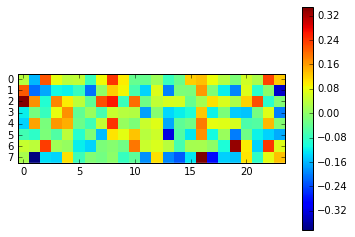

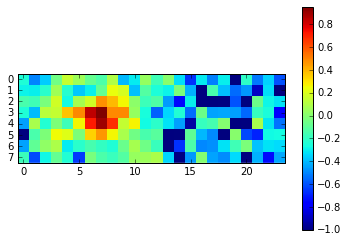

In [44]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    %matplotlib inline
    plt.imshow(b[0,0],interpolation='none')
    plt.colorbar()
    plt.figure(2)
    plt.imshow(xtr[0,0],interpolation='none')
    plt.colorbar()

In [14]:
if __name__ == "__main__":
    xtr,xv,xte = get_ibd_data(tot_num_pairs=30, preprocess=True)
    for x in [xtr,xv,xte]:
        assert(x.min() > -1.1)
        assert (x.max() < 1.1)
